In [1]:
import os
import glob
import pandas as pd
import numpy as np


We will start by reading in GPS file with power values. To get this file a cleaned GPS file went through some propriety software. 

In [2]:
df=pd.read_csv('DF4.csv' , header=0, low_memory=False)
df=df.drop('T-T0',axis=1)
df=df.drop('distanceTravelledSinceLastPoint',axis=1)
df.head()

,T_T0_s,latitude,longitude,altitude,velocityAbs,acceleration,power
0,0.000000,51.760891,-1.261531,114.152164,0.003096,2.140747e-11,1.139526
1,0.020015,51.760891,-1.261531,114.152219,0.003121,1.270351e-02,-36.986994
2,0.040029,51.760891,-1.261531,114.152275,0.003208,4.326055e-02,-37.681035
3,0.060044,51.760891,-1.261531,114.152332,0.003341,6.642054e-02,-49.998600
4,0.080059,51.760891,-1.261531,114.152390,0.003168,-8.621679e-02,-33.629682


The above dataframe shows that the Time interval is approximately every 0.02 seconds. Lets group these together to the nearest seconds, taking an average of the values in between:

In [3]:
Tmax=int(df.T_T0_s.max())
bins = np.linspace(df.T_T0_s.min(), Tmax, Tmax+1)
df4_group = df.groupby(np.digitize(df.T_T0_s, bins)).mean()
df4_group.head()

,T_T0_s,latitude,longitude,altitude,velocityAbs,acceleration,power
1,0.499973,51.760891,-1.261531,114.151619,0.004138,0.029414,-28.537602
2,1.509922,51.760891,-1.261531,114.155556,0.006637,0.015816,-65.941776
3,2.509888,51.760891,-1.261531,114.155135,0.006002,-0.018576,-6.876422
4,3.509872,51.760891,-1.261531,114.155515,0.005300,0.004647,-38.007377
5,4.509881,51.760891,-1.261531,114.155923,0.006449,0.007402,-59.623393


Now lets see what is correlated to power:

In [4]:
dfcorr = df4_group.corr(method='spearman')['power']
dfcorr = pd.DataFrame(dfcorr)
dfcorr.columns = ["Correlation"]
dfcorr2 = dfcorr.sort_values(by=['Correlation'], ascending=False)
print(dfcorr2)

              Correlation
power            1.000000
acceleration     0.832258
longitude        0.015997
altitude         0.005234
T_T0_s           0.005173
latitude         0.002096
velocityAbs     -0.024941


Only acceleration is highly correlated. 
What about viewing this as a time series?

In [5]:
Pseries=pd.Series(df4_group['power'])
values = pd.DataFrame(Pseries.values)

dataframe = pd.concat([values, values.shift(1), values.shift(2), values.shift(3), values.shift(4), values.shift(5), values.shift(6), values.shift(7), values.shift(8), values.shift(9), values.shift(10)], axis=1)
dataframe.head()
dataframe.columns = ['t', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10']
result = dataframe.corr()
print(result.iloc[0])


t       1.000000
t+1     0.813595
t+2     0.530375
t+3     0.285426
t+4     0.115904
t+5     0.018619
t+6    -0.035054
t+7    -0.054886
t+8    -0.060359
t+9    -0.068716
t+10   -0.082963
Name: t, dtype: float64


Now we have correlations up to about 5 seconds. Lets use VAR with acceleration and power so we can use both a time series approach and to exploit the strong correlations with acceleration.

In [6]:
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
warnings.filterwarnings("ignore")
df=df4_group[['acceleration', 'power']]

test=df.iloc[6:]
#train=long_df.iloc[0:5]
#for t in range(0,1):
predictions=[]
actuals=[]
d=1500
for t in range(0,len(test)-d):
    train=df.iloc[t:t+d-1]
    to_test=test.iloc[t+d]
    actuals.append(to_test['power'])
    model = VAR(train)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.y, steps=1)
    prediction=prediction[0]
    predictions.append(prediction[-1])

Lets plot predictions versus actuals

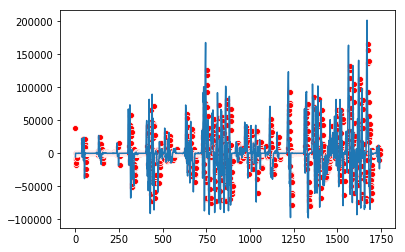

In [9]:
import seaborn as sns
test_x=range(0,len(predictions))
ax = sns.scatterplot(x=test_x, y=predictions,color='red')
ax = sns.lineplot(x=test_x, y=actuals)

What is the error?

In [10]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(actuals, predictions)
print('Test MAE: %.3f' % error)

Test MAE: 24821.445


Wow thats a big error! Looks like a lot more work needs to be done

Note: This is a simplified version of the final product that was handed over to the company. The full and far more accurate version is in their hands to be implemented soon. 

I hope you've enjoyed this notebook. 